In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from comparers import ModelComparer, plot_decision_boundary
from diro2c_wrapper import WrappedDiro2C, plot_diro2c_2d, get_pruned_trees, eval_diro2c, get_generated_data
from surrogate_tree import get_feature_importances, plot_feature_importances, plot_surrogate_tree,\
                           extract_rules, print_rules, plot_rules_of_tree_for_class
from util import RuleClassifier, evaluate_counterfactual_fidelity, get_complexity, group_metrics

In [2]:
with open('data/task.pickle', 'rb') as f:
    clf_a, clf_b, X, y, feature_names, feature_precisions = pickle.load(f)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

# Explanations

In [5]:
%%time
for class_name in comparer.class_names:
    print(class_name)
    explainer = WrappedDiro2C(X, comparer, class_name)
    explanation = explainer.generate_global_explanation()
    with open(f'explanations/diro2c.{class_name}.pickle', 'wb') as f:
        pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

(0, 0)
(0, 1)
(1, 0)
(1, 1)
CPU times: user 13min 7s, sys: 5.9 s, total: 13min 13s
Wall time: 13min 33s


## (0,1)

In [5]:
focus_class = '(0, 1)'
y_true = comparer.class_names[mclass_diff] == focus_class

In [6]:
with open(f'explanations/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

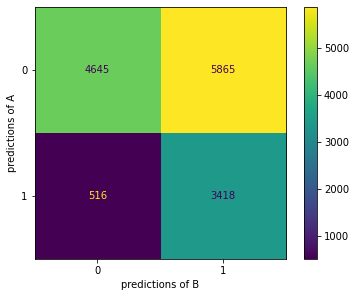

In [7]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('figures/bign-diro2c-cf-01.pdf')

In [8]:
%%time
trees = get_pruned_trees(explanation)
tree_it = iter(trees)
len(trees)

CPU times: user 310 ms, sys: 4.94 ms, total: 315 ms
Wall time: 320 ms


23

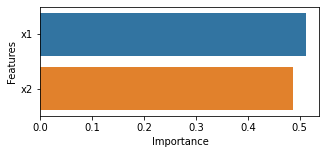

In [9]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order)

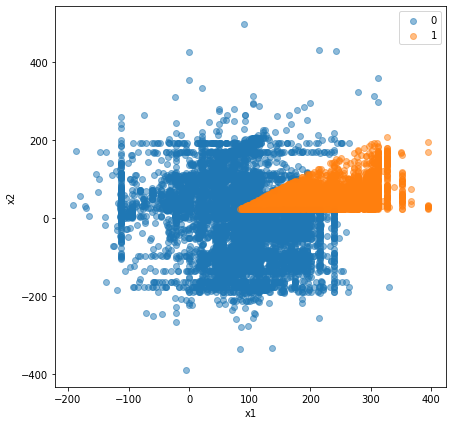

In [10]:
plot_diro2c_2d(explanation, 'x1', 'x2')

### 2 Leafs

In [11]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.16818056015717134, 1, 2)

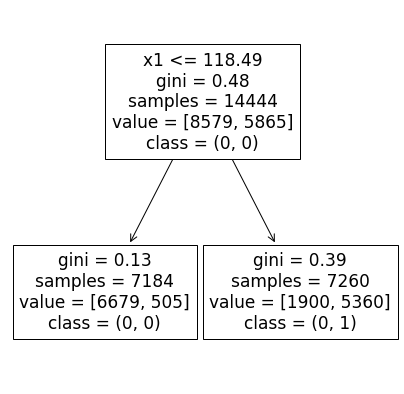

In [12]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(7, 7))

In [13]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 > 118.5 => (0, 1) [1900, 5360]


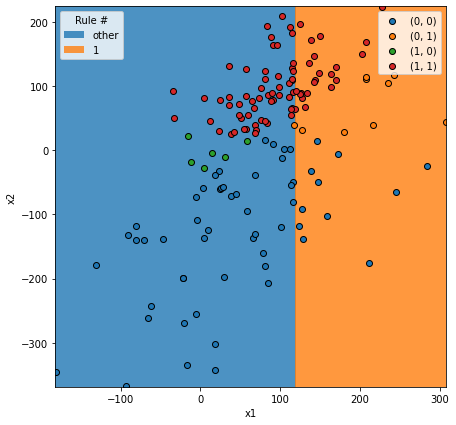

In [14]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 3 Leafs

In [15]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.018749560355942774, 2, 3)

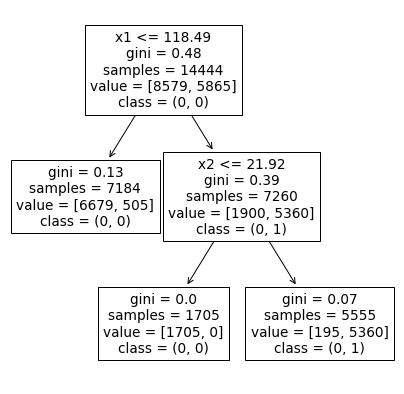

In [16]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(7, 7))

In [17]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 > 118.5 and x2 > 21.9 => (0, 1) [195, 5360]


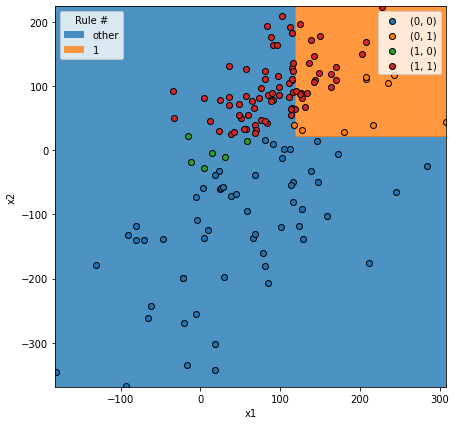

In [18]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 6 Leafs

In [19]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.008883025922501463, 4, 6)

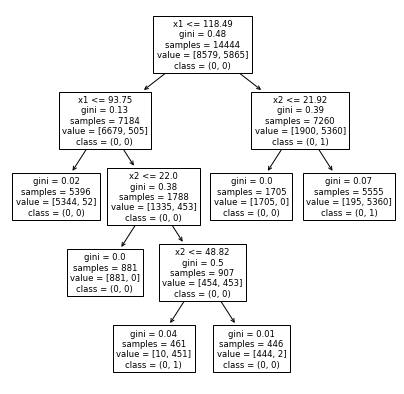

In [20]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(7, 7))

In [21]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 > 118.5 and x2 > 21.9 => (0, 1) [195, 5360]
2. 93.7 < x1 <= 118.5 and 22.0 < x2 <= 48.8 => (0, 1) [10, 451]


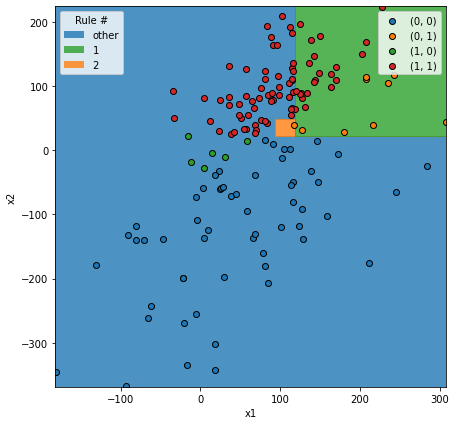

In [22]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 7 Leafs

In [23]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.004726587503410984, 4, 7)

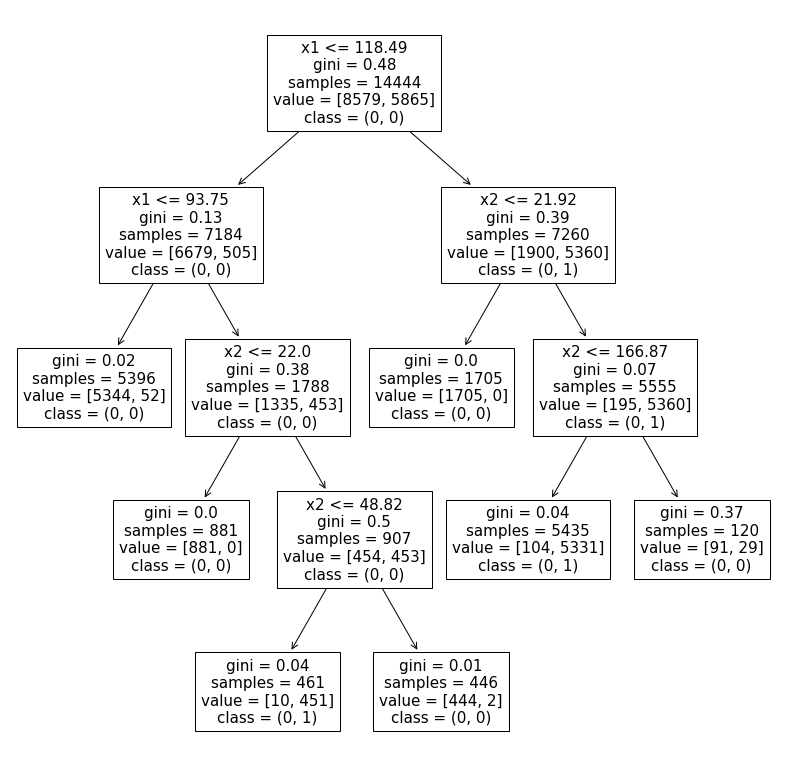

In [24]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(14, 14))

In [25]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 > 118.5 and 21.9 < x2 <= 166.9 => (0, 1) [104, 5331]
2. 93.7 < x1 <= 118.5 and 22.0 < x2 <= 48.8 => (0, 1) [10, 451]


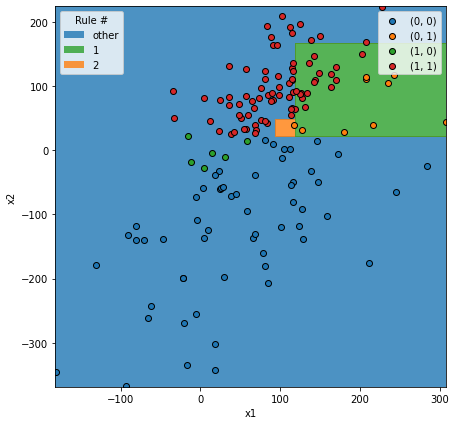

In [26]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 9 Leafs

In [27]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.0025583654322230893, 5, 9)

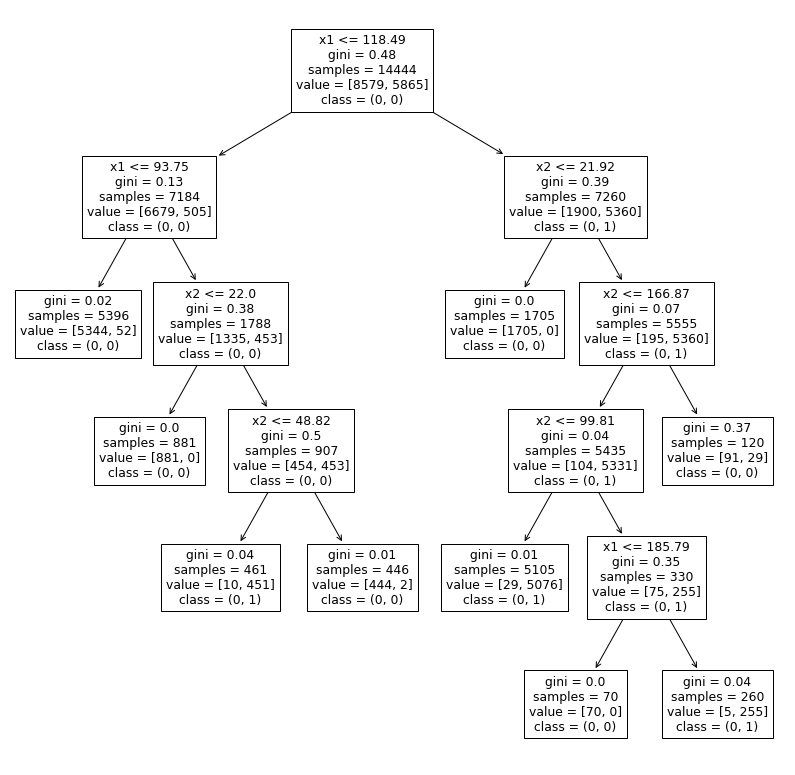

In [28]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(14, 14))

In [29]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 > 118.5 and 21.9 < x2 <= 99.8 => (0, 1) [29, 5076]
2. 93.7 < x1 <= 118.5 and 22.0 < x2 <= 48.8 => (0, 1) [10, 451]
3. x1 > 185.8 and 99.8 < x2 <= 166.9 => (0, 1) [5, 255]


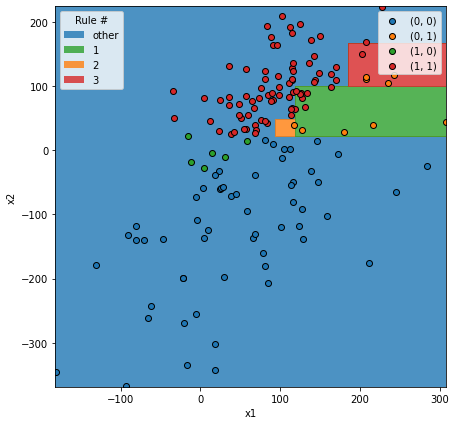

In [30]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

## $(1,0)$

In [31]:
focus_class = '(1, 0)'
y_true = comparer.class_names[mclass_diff] == focus_class

In [32]:
with open(f'explanations/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

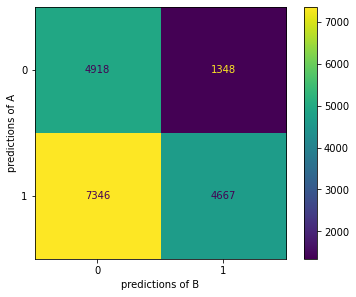

In [33]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('figures/bign-diro2c-cf-10.pdf')

In [34]:
%%time
trees = get_pruned_trees(explanation)
tree_it = iter(trees)
len(trees)

CPU times: user 962 ms, sys: 20 ms, total: 982 ms
Wall time: 1.09 s


48

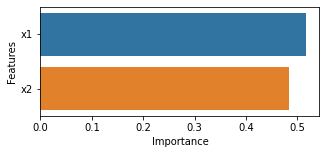

In [35]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order)

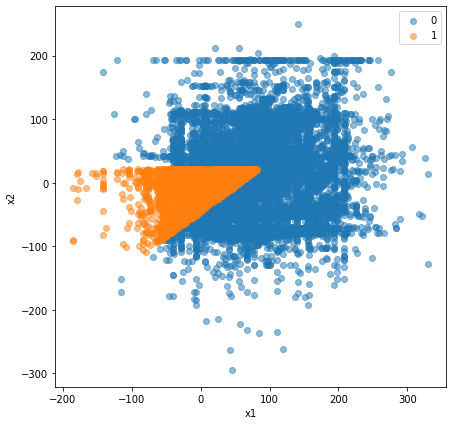

In [36]:
plot_diro2c_2d(explanation, 'x1', 'x2')

### 2 Leafs

In [37]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.10218290812148145, 1, 2)

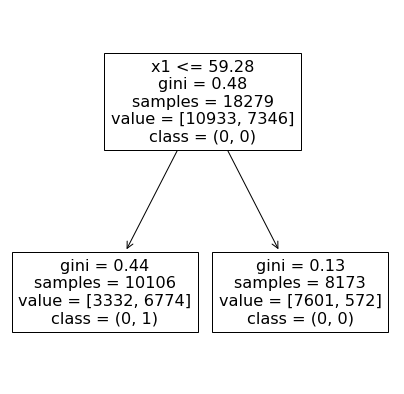

In [38]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(7, 7))

In [39]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 <= 59.3 => (0, 1) [3332, 6774]


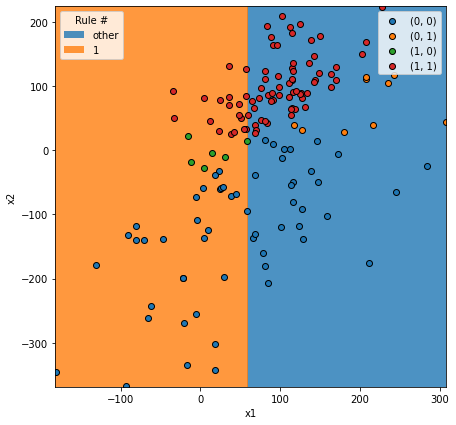

In [40]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 3 Leafs

In [41]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.05095453450923265, 2, 3)

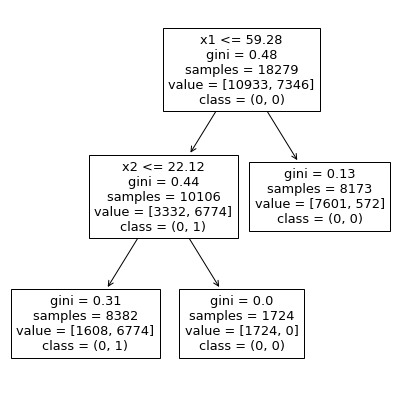

In [42]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(7, 7))

In [43]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 <= 59.3 and x2 <= 22.1 => (0, 1) [1608, 6774]


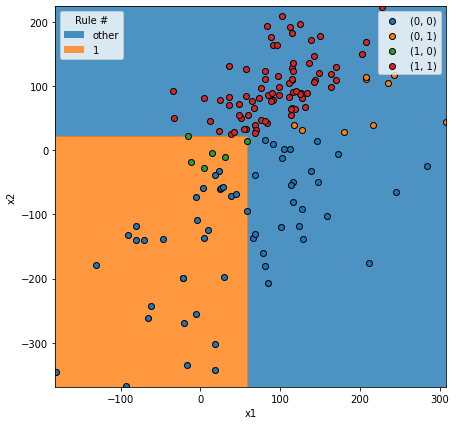

In [44]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 4 Leafs

In [45]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.030413352908594544, 3, 4)

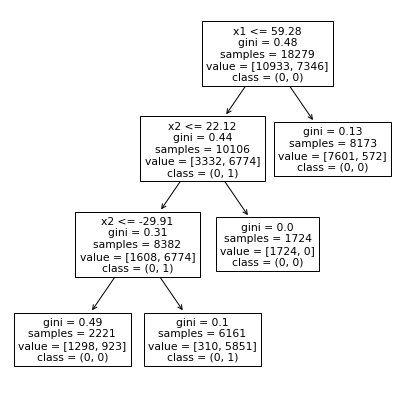

In [46]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(7, 7))

In [47]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 <= 59.3 and -29.9 < x2 <= 22.1 => (0, 1) [310, 5851]


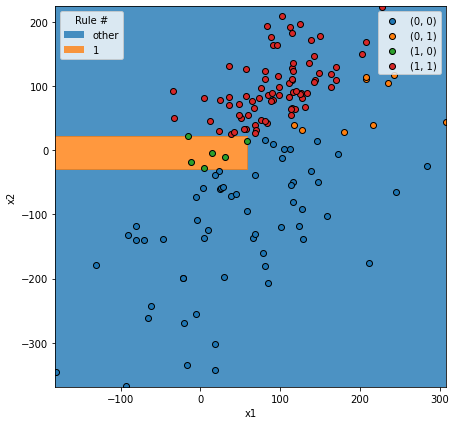

In [48]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 5 Leafs

In [49]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.016560707773399155, 4, 5)

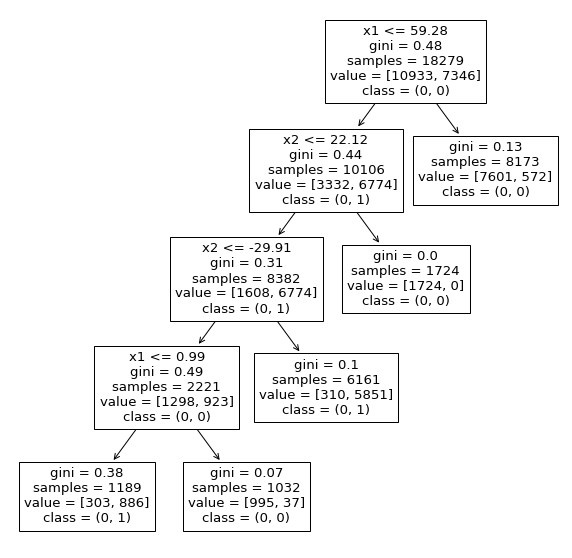

In [50]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(10, 10))

In [51]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 <= 59.3 and -29.9 < x2 <= 22.1 => (0, 1) [310, 5851]
2. x1 <= 1.0 and x2 <= -29.9 => (0, 1) [303, 886]


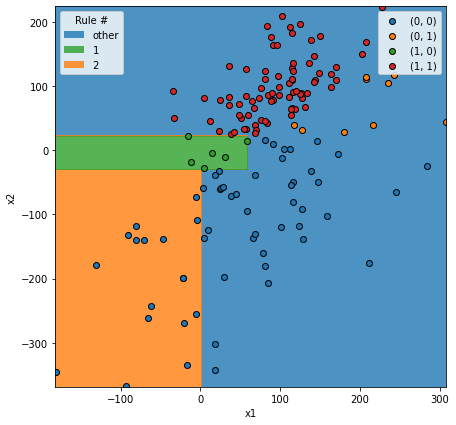

In [52]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 8 Leafs

In [53]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.007464896717550013, 4, 8)

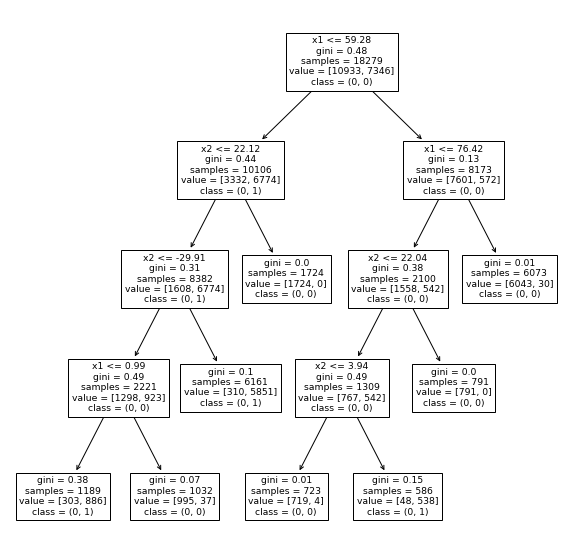

In [54]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(10, 10))

In [55]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 <= 59.3 and -29.9 < x2 <= 22.1 => (0, 1) [310, 5851]
2. x1 <= 1.0 and x2 <= -29.9 => (0, 1) [303, 886]
3. 59.3 < x1 <= 76.4 and 3.9 < x2 <= 22.0 => (0, 1) [48, 538]


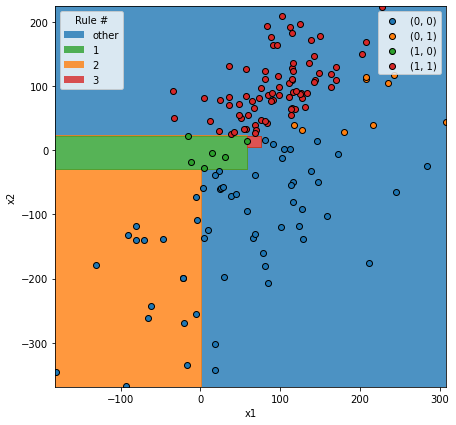

In [56]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 10 Leafs

In [57]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.0051036106041802, 5, 10)

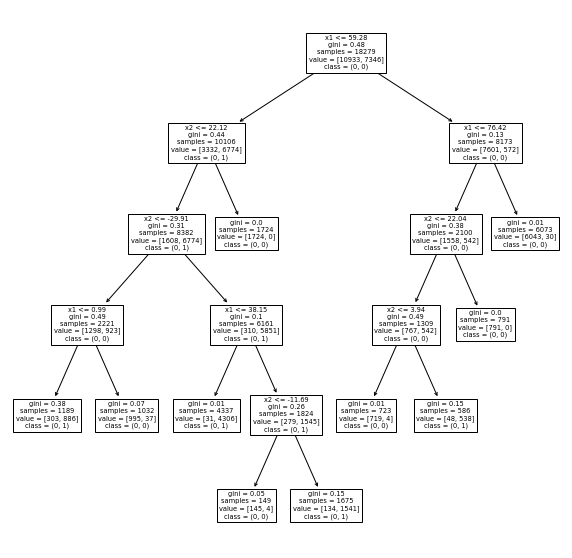

In [58]:
plot_surrogate_tree(tree, feature_names, comparer.class_names, precision=2, figsize=(10, 10))

In [59]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 <= 38.2 and -29.9 < x2 <= 22.1 => (0, 1) [31, 4306]
2. 38.2 < x1 <= 59.3 and -11.7 < x2 <= 22.1 => (0, 1) [134, 1541]
3. x1 <= 1.0 and x2 <= -29.9 => (0, 1) [303, 886]
4. 59.3 < x1 <= 76.4 and 3.9 < x2 <= 22.0 => (0, 1) [48, 538]


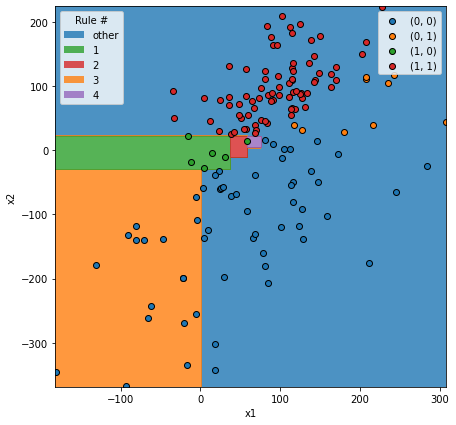

In [60]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 11 Leafs

In [61]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.0045365383538313025, 5, 11)

In [62]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 <= 38.2 and -29.9 < x2 <= 22.1 => (0, 1) [31, 4306]
2. 38.2 < x1 <= 59.3 and -11.7 < x2 <= 22.1 => (0, 1) [134, 1541]
3. x1 <= 1.0 and -79.7 < x2 <= -29.9 => (0, 1) [180, 845]
4. 59.3 < x1 <= 76.4 and 3.9 < x2 <= 22.0 => (0, 1) [48, 538]


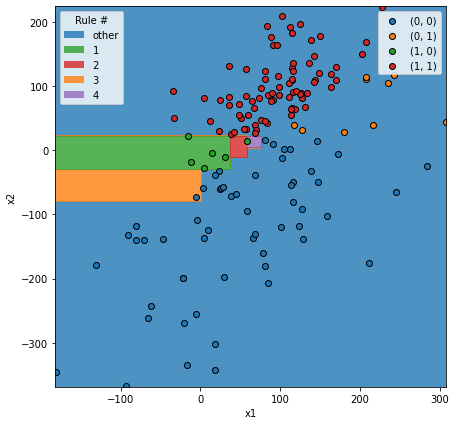

In [63]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

# Evaluation

In [64]:
with open('data/test.pickle', 'rb') as f:
    X_test, y_test = pickle.load(f)

In [65]:
explanations_per_class = {}
for class_name in comparer.class_names:
    with open(f'explanations/diro2c.{class_name}.pickle', 'rb') as f:
        explanations_per_class[class_name] = pickle.load(f)

In [66]:
metrics = eval_diro2c(explanations_per_class, X_test, y_test, comparer.class_names)
metrics

,Precision,Recall,F1 Score,Support,Label,Leafs,Alpha,Rules,Constraints
1,0.780041,1.000000,0.876430,4213.0,"(0, 0)",2.0,0.019427,1.0,1.0
1,0.880260,0.998101,0.935484,4213.0,"(0, 0)",4.0,0.010886,2.0,4.0
1,0.917067,0.997389,0.955543,4213.0,"(0, 0)",6.0,0.001889,3.0,7.0
1,0.922503,0.997389,0.958485,4213.0,"(0, 0)",8.0,0.001668,4.0,11.0
1,0.933985,0.997389,0.964646,4213.0,"(0, 0)",10.0,0.001171,5.0,14.0
...,...,...,...,...,...,...,...,...,...
1,0.986740,0.998323,0.992498,3578.0,"(1, 1)",68.0,0.000059,34.0,125.0
1,0.986744,0.998603,0.992638,3578.0,"(1, 1)",70.0,0.000058,35.0,129.0
1,0.986472,0.998603,0.992500,3578.0,"(1, 1)",72.0,0.000053,36.0,133.0
1,0.986472,0.998603,0.992500,3578.0,"(1, 1)",74.0,0.000045,37.0,137.0


In [67]:
grouped_metrics, constraints = group_metrics(metrics, by='Alpha')

In [68]:
with open('data/fidelity-diro2c.pickle', 'wb') as f:
    pickle.dump((grouped_metrics, constraints), f)

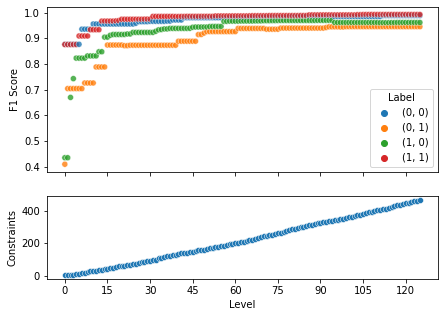

In [69]:
fig, axs = plt.subplots(nrows=2, figsize=(7, 5), sharex='all', gridspec_kw={'height_ratios': [2,1]})
sns.scatterplot(data=grouped_metrics, x='Level', y='F1 Score', hue='Label', alpha=0.8, ax=axs[0])
sns.scatterplot(data=constraints, ax=axs[1])
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

In [70]:
grouped_metrics

Label  Precision    Recall  F1 Score  Support  Leafs     Alpha  \
Level                                                                      
0     0  (0, 0)   0.780041  1.000000  0.876430   4213.0    2.0  0.019427   
      1  (0, 1)   0.262286  0.930460  0.409218   1021.0    2.0  0.168181   
      2  (1, 0)   0.280214  0.968013  0.434618   1188.0    2.0  0.102183   
      3  (1, 1)   0.779255  0.999441  0.875719   3578.0    2.0  0.025652   
1     0  (0, 0)   0.780041  1.000000  0.876430   4213.0    2.0  0.019427   
...         ...        ...       ...       ...      ...    ...       ...   
124   3  (1, 1)   0.986472  0.998603  0.992500   3578.0   74.0  0.000045   
125   0  (0, 0)   0.980168  0.997152  0.988587   4213.0   46.0  0.000000   
      1  (0, 1)   0.897797  0.998041  0.945269   1021.0   42.0  0.000000   
      2  (1, 0)   0.958961  0.963805  0.961377   1188.0   96.0  0.000000   
      3  (1, 1)   0.986472  0.998603  0.992500   3578.0   76.0  0.000000   

         Rules  Constraints  
Level                        
0     0    1.0          1.0  
      1    1.0          1.0  
      2    1.0          1.0  
      3    1.0          1.0  
1     0    1.0          1.0  
...        ...          ...  
124   3   37.0        137.0  
125   0   23.0         80.0  
      1   19.0         70.0  
      2   46.0        175.0  
      3   38.0        141.0  

[504 rows x 9 columns]

In [71]:
constraints

Level
0        4.0
1        5.0
2        6.0
3        7.0
4        9.0
       ...  
121    450.0
122    454.0
123    458.0
124    462.0
125    466.0
Name: Constraints, Length: 126, dtype: float64

# Additional Material

In [72]:
tree = get_pruned_trees(explanations_per_class['(0, 1)'])[4]

In [74]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions, latex=True)
for rule in rules:
    print(f'\item if ${rule}$, then $(0, 1)$')

\item if $\mathit{x_1} > 118.5 \land 21.9 < \mathit{x_2} \leq 99.8$, then $(0, 1)$
\item if $93.7 < \mathit{x_1} \leq 118.5 \land 22.0 < \mathit{x_2} \leq 48.8$, then $(0, 1)$
\item if $\mathit{x_1} > 185.8 \land 99.8 < \mathit{x_2} \leq 166.9$, then $(0, 1)$


In [75]:
tree = get_pruned_trees(explanations_per_class['(1, 0)'])[6]

In [76]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions, latex=True)
for rule in rules:
    print(f'\item if ${rule}$, then $(1, 0)$')

\item if $\mathit{x_1} \leq 38.2 \land -29.9 < \mathit{x_2} \leq 22.1$, then $(1, 0)$
\item if $38.2 < \mathit{x_1} \leq 59.3 \land -11.7 < \mathit{x_2} \leq 22.1$, then $(1, 0)$
\item if $\mathit{x_1} \leq 1.0 \land -79.7 < \mathit{x_2} \leq -29.9$, then $(1, 0)$
\item if $59.3 < \mathit{x_1} \leq 76.4 \land 3.9 < \mathit{x_2} \leq 22.0$, then $(1, 0)$
